# Summary

In this notebook, we analyze restaurant reviews to identify key differences between 1-star and 5-star reviews. We utilize various text processing techniques, including tokenization, stopword removal, stemming, and lemmatization. We also extract and analyze frequently used nouns, adjectives, verbs, and named entities to understand the language and sentiments expressed in the reviews. Visualizations such as word clouds help in highlighting distinctive words and entities in the reviews. The analysis aims to uncover insights into what contributes to negative and positive dining experiences.

# Code Cell 1
    Library and data import. Show the summary of the input data.

In [1]:
# Import necessary libraries
import pandas as pd
from collections import Counter
import spacy
import tkinter as tk
from tkinter import filedialog
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import contractions
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import re

# Ensure NLTK resources are downloaded
nltk.download('omw-1.4')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

# Load the English NLP model
nlp = spacy.load("en_core_web_sm")

# Create a Tkinter root window
root = tk.Tk()
root.withdraw()  # Hide the root window

# Open a file dialog to select the CSV file
file_path = filedialog.askopenfilename(title="Select the restaurant reviews CSV file", filetypes=[("CSV files", "*.csv")])

# Read the selected CSV file
data = pd.read_csv(file_path)

# Drop NA values
data = data.dropna()
# only keep stars and text columns
data = data[['stars', 'text']]

# Show the summary of the input data
# Display the first few rows and summary statistics of the dataset
print(data.head())
print(data.describe())


[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/msgfrom96/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /Users/msgfrom96/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/msgfrom96/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/msgfrom96/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/msgfrom96/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
2025-01-26 13:53:23.384 python[17664:776849] +[IMKClient subclass]: chose IMKClient_Legacy
2025-01-26 13:53:23.937 python[17664:776849] The class 'NSOpenPanel' overrides the method identifier.  This method is implemented by class 'NSWindow'


   stars                                               text
0      3  OK, the hype about having Hatch chili in your ...
1      5  Pandemic pit stop to have an ice cream.... onl...
2      5  I was lucky enough to go to the soft opening a...
3      5  I've gone to claim Jumpers all over the US and...
4      4  If you haven't been  to Maynard's kitchen, it'...
              stars
count  48147.000000
mean       3.736702
std        1.557289
min        1.000000
25%        2.000000
50%        5.000000
75%        5.000000
max        5.000000


# Code Cell 2
    Select the 1 star reviews and 5 star reviews from the dataset. 


In [2]:
# Select the 1 star reviews from the dataset
one_star_reviews = data[data['stars'] == 1]
print("1 Star Reviews:")
print(one_star_reviews.head())

# Select the 5 star reviews from the dataset
five_star_reviews = data[data['stars'] == 5]
print("5 Star Reviews:")
print(five_star_reviews.head())

# Display the counts of each
print(f"1 Star Reviews Count: {len(one_star_reviews)}")
print(f"5 Star Reviews Count: {len(five_star_reviews)}")

1 Star Reviews:
    stars                                               text
5       1  I stay at the Main Hotel at the Casino from Ju...
13      1  I don't know what happened to this place but e...
18      1  Very bad service call for takeout they got our...
20      1  This place is not worth it. Don't go the food ...
22      1  I was so looking forward to Del Sols re-openin...
5 Star Reviews:
   stars                                               text
1      5  Pandemic pit stop to have an ice cream.... onl...
2      5  I was lucky enough to go to the soft opening a...
3      5  I've gone to claim Jumpers all over the US and...
6      5  In town after a long weekend of hiking and cam...
7      5  This is the definition of a great family-run b...
1 Star Reviews Count: 8466
5 Star Reviews Count: 24467


# Code Cell 3
    Apply necessary text processing techniques on the selected reviews. 


In [3]:
# Define a dictionary for common contractions and their corrections
# This dictionary helps in expanding common contractions to their full forms,
# which can improve the readability and understanding of the text.
contractions_cleaned = {
    r"\bive\b": "I've",
    r"\bdont\b": "don't",
    r"\bcant\b": "can't",
    r"\bwont\b": "won't",
    r"\bim\b": "I'm",
    r"\byoure\b": "you're",
    r"\bhes\b": "he's",
    r"\bshes\b": "she's",
    r"\bits\b": "it's",
    r"\btheyre\b": "they're",
    r"\bwhats\b": "what's",
    r"\btheres\b": "there's",
    r"\bcouldve\b": "could've",
    r"\bshouldve\b": "should've",
    r"\bwouldve\b": "would've",
    r"\bmightve\b": "might've",
    r"\bmustve\b": "must've",
    r"\bid\b": "I'd",
    r"\byoull\b": "you'll",
    r"\byoud\b": "you'd",
    r"\btheyll\b": "they'll",
    r"\btheyve\b": "they've",
    r"\bill\b": "I'll",
    r"\blets\b": "let's",
    r"\bthats\b": "that's",
    r"\bwhos\b": "who's",
    r"\bwhove\b": "who've",
    r"\barent\b": "aren't",
    r"\bisnt\b": "isn't",
    r"\bwasnt\b": "wasn't",
    r"\bwerent\b": "weren't",
    r"\bhavent\b": "haven't",
    r"\bhasnt\b": "hasn't",
    r"\bhadnt\b": "hadn't",
    r"\bshouldnt\b": "shouldn't",
    r"\bcouldnt\b": "couldn't",
    r"\bmightnt\b": "mightn't",
    r"\bmustnt\b": "mustn't",
    r"\bneednt\b": "needn't",
    r"\bwouldnt\b": "wouldn't",
    r"\bu\b": "you"
}

# Define a function to preprocess the reviews
def preprocess_reviews(reviews):
    # Print first 5 reviews before processing
    # This helps in understanding the initial state of the reviews.
    print("Reviews before processing:")
    print(reviews.head(1))

    # Expand contractions in the reviews using the contractions cleaned dictionary
    # This step ensures that all contractions are properly expanded for better analysis.
    reviews = reviews.replace(contractions_cleaned, regex=True)

    # Use contractions library to expand contractions
    # This further ensures that any remaining contractions are handled.
    reviews = reviews.apply(lambda x: contractions.fix(x))

    # Convert to lowercase
    # Lowercasing helps in standardizing the text, making it easier to compare words.
    reviews = reviews.apply(lambda x: x.lower())
    
    # Tokenization
    # Tokenization splits the text into individual words, which is essential for further processing.
    reviews = reviews.apply(word_tokenize)

    # Stopword removal
    # Stopwords are common words that may not add significant meaning to the text,
    # removing them can help focus on more meaningful words.
    stop_words = set(stopwords.words('english'))
    reviews = reviews.apply(lambda x: [word for word in x if word not in stop_words])
    
    # Print reviews after processing
    # This helps in verifying the changes made during preprocessing.
    print("Reviews after processing:")
    print(reviews.head(1))
    
    return reviews

# Preprocess the 1 star and 5 star reviews
# This step applies the preprocessing function to both sets of reviews to prepare them for analysis.
one_star_reviews_cleaned = preprocess_reviews(one_star_reviews['text'])
five_star_reviews_cleaned = preprocess_reviews(five_star_reviews['text'])


Reviews before processing:
5    I stay at the Main Hotel at the Casino from Ju...
Name: text, dtype: object
Reviews after processing:
5    [stay, main, hotel, casino, july, 11, july, 13...
Name: text, dtype: object
Reviews before processing:
1    Pandemic pit stop to have an ice cream.... onl...
Name: text, dtype: object
Reviews after processing:
1    [pandemic, pit, stop, ice, cream, ...., plain,...
Name: text, dtype: object


### Additionally, we will generate a lemmatized and stemmed version of the reviews in case we need to use it later

In [4]:

# Define a function for stemming
def stem_words(words):
    return [stemmer.stem(word) for word in words]

# Define a function for lemmatization
def lemmatize_words(words):
    return [lemmatizer.lemmatize(word) for word in words]


# Initialize stemmer and lemmatizer
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

# Generate a lemmatized and stemmed version after cleaning
one_star_reviews_lemmatized_stemmed = one_star_reviews_cleaned.apply(lemmatize_words).apply(stem_words)
five_star_reviews_lemmatized_stemmed = five_star_reviews_cleaned.apply(lemmatize_words).apply(stem_words)

# Bag of Words representation
bow_vectorizer = CountVectorizer(tokenizer=lambda x: x, lowercase=False)
one_star_bow = bow_vectorizer.fit_transform(one_star_reviews_cleaned)
five_star_bow = bow_vectorizer.transform(five_star_reviews_cleaned)

# TF-IDF representation
tfidf_vectorizer = TfidfVectorizer(tokenizer=lambda x: x, lowercase=False)
one_star_tfidf = tfidf_vectorizer.fit_transform(one_star_reviews_cleaned)
five_star_tfidf = tfidf_vectorizer.transform(five_star_reviews_cleaned)

# Print text of cleaned reviews
print("Cleaned 1 Star Reviews:")
print(one_star_reviews_cleaned)
print("\nCleaned 5 Star Reviews:")
print(five_star_reviews_cleaned)

/Users/msgfrom96/anaconda3/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Cleaned 1 Star Reviews:
5        [stay, main, hotel, casino, july, 11, july, 13...
13       [know, happened, place, ever, since, moved, bi...
18       [bad, service, call, takeout, got, order, wron...
20       [place, worth, ., go, food, good, service, hor...
22       [looking, forward, del, sols, re-opening, toda...
                               ...                        
48122    [good, ., struggle, order, family, meal, go, ....
48129    [mom, went, lunch, august, 30th, food, really,...
48135    [popeyes, years, years, ...., nearby, decided,...
48137    [girlfriend, wanted, burger, usually, eat-out,...
48144    [could, leave, stars, would, ., understand, bu...
Name: text, Length: 8466, dtype: object

Cleaned 5 Star Reviews:
1        [pandemic, pit, stop, ice, cream, ...., plain,...
2        [lucky, enough, go, soft, opening, let, tell, ...
3        [gone, claim, jumpers, us, never, disappoint, ...
6        [town, long, weekend, hiking, camping, ., burg...
7        [definition, grea

# Code Cell 4
    Find the top 20 frequently used nouns in 1 star reviews and 5 star reviews, respectively.


In [5]:
# Function to extract lemmatized nouns
def get_top_nouns(reviews_cleaned):
    # Flatten the list of tokenized reviews
    tokens = [word for review in reviews_cleaned for word in review]
    tagged = nltk.pos_tag(tokens)
    lemmatized_nouns = [lemmatizer.lemmatize(word) for word, pos in tagged if pos in ['NN', 'NNS', 'NNP', 'NNPS']]
    return Counter(lemmatized_nouns).most_common(20)

# Get top 20 lemmatized nouns for 1 star and 5 star reviews
top_nouns_one_star = get_top_nouns(one_star_reviews_cleaned)
top_nouns_five_star = get_top_nouns(five_star_reviews_cleaned)

print("Top 20 Nouns in 1 Star Reviews:", top_nouns_one_star)
print("Top 20 Nouns in 5 Star Reviews:", top_nouns_five_star)


Top 20 Nouns in 1 Star Reviews: [('food', 6602), ('order', 5395), ('time', 4331), ('place', 3303), ('service', 3090), ('minute', 2510), ('customer', 2212), ('restaurant', 1921), ('manager', 1655), ('people', 1473), ('hour', 1261), ('location', 1191), ('way', 1162), ('experience', 1123), ('staff', 1047), ('employee', 1035), ('drink', 992), ('table', 976), ('pizza', 952), ('meal', 884)]
Top 20 Nouns in 5 Star Reviews: [('food', 16034), ('place', 10733), ('service', 7527), ('time', 7057), ('tucson', 4264), ('restaurant', 4210), ('staff', 4196), ('order', 4054), ('everything', 2944), ('menu', 2554), ('flavor', 2462), ('pizza', 2453), ('experience', 2226), ('meal', 2156), ('taco', 2138), ('chicken', 2133), ('drink', 2054), ('sauce', 1961), ('try', 1956), ('spot', 1945)]


## I want to now find something more interesting, as words are repeated in both 1 and 5 star reviews.

Top 20 Distinctive Words in 1-Star Reviews:
minute: 2510
manager: 1655
money: 857
min: 564
management: 399
charge: 320
bill: 300
attitude: 288
refund: 282
waste: 279
hair: 221
mistake: 205
mcdonald: 175
response: 173
health: 165
disappointment: 159
mess: 156
apology: 156
receipt: 155
trash: 146

Top 20 Distinctive Words in 5-Star Reviews:
place: 10733
tucson: 4264
staff: 4196
everything: 2944
menu: 2554
flavor: 2462
taco: 2138
spot: 1945
price: 1847
breakfast: 1763
side: 1745
family: 1742
option: 1659
town: 1654
dish: 1553
salad: 1521
lunch: 1502
portion: 1471
lot: 1399
area: 1328


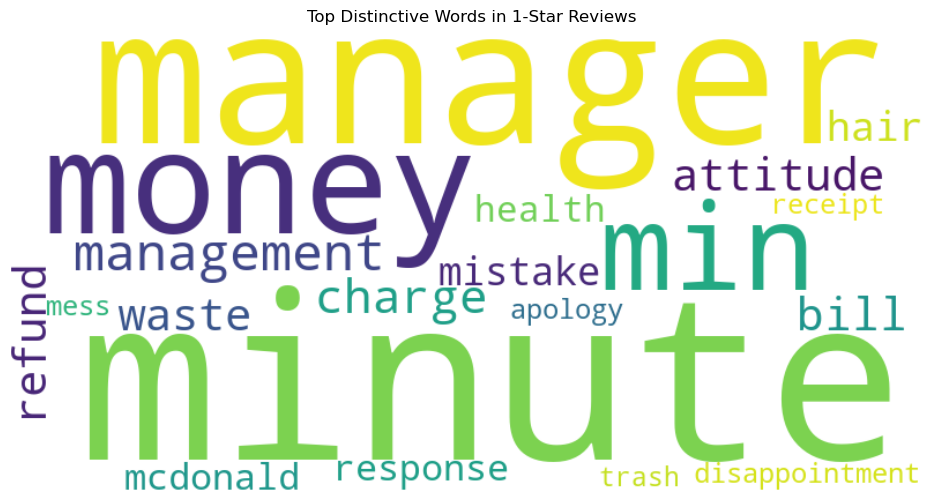

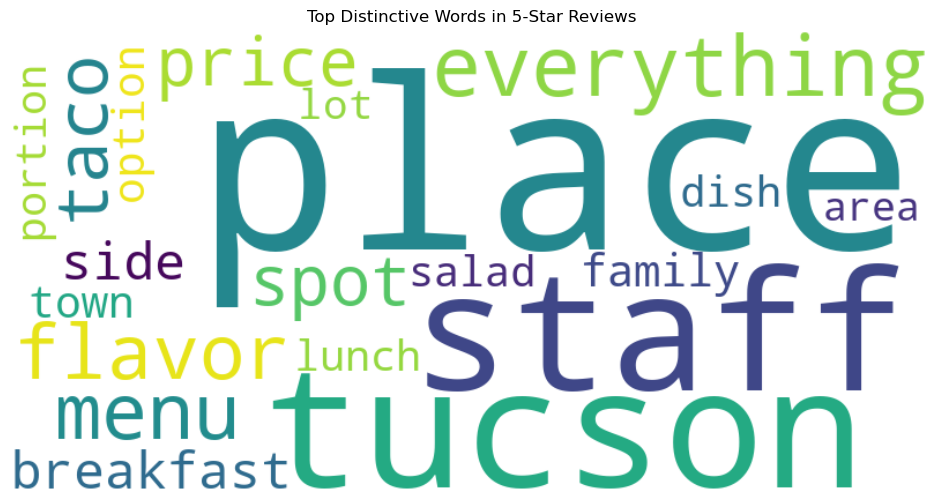

In [6]:
# Function to extract lemmatized nouns
def get_top_nouns(reviews_cleaned):
    # Flatten the list of tokenized reviews
    tokens = [word for review in reviews_cleaned for word in review]
    tagged = nltk.pos_tag(tokens)
    # Only include nouns and exclude adjectives and verbs that were incorrectly tagged
    lemmatized_nouns = [lemmatizer.lemmatize(word.lower()) for word, pos in tagged 
                       if (pos.startswith('NN') or pos in ['NNP', 'NNPS', 'NNS']) 
                       and word.lower() not in ['rude', 'cold', 'bland', 'dirty', 'try']]
    return Counter(lemmatized_nouns)

# Get lemmatized nouns for both star ratings
one_star_counter = get_top_nouns(one_star_reviews_cleaned)
five_star_counter = get_top_nouns(five_star_reviews_cleaned)

# Find words that appear significantly more in one rating vs the other
one_star_unique = {}
five_star_unique = {}

for word in set(one_star_counter.keys()) | set(five_star_counter.keys()):
    one_count = one_star_counter.get(word, 0)
    five_count = five_star_counter.get(word, 0)
    
    # If word appears at least 3x more in one rating
    if one_count > five_count * 3:
        one_star_unique[word] = one_count
    elif five_count > one_count * 3:
        five_star_unique[word] = five_count

# Get top 20 words for each rating
final_one_star = sorted(one_star_unique.items(), key=lambda x: x[1], reverse=True)[:20]
final_five_star = sorted(five_star_unique.items(), key=lambda x: x[1], reverse=True)[:20]

# Display results
print("Top 20 Distinctive Words in 1-Star Reviews:")
for word, count in final_one_star:
    print(f"{word}: {count}")

print("\nTop 20 Distinctive Words in 5-Star Reviews:")
for word, count in final_five_star:
    print(f"{word}: {count}")

# Prepare data for visualization
words_one_star, counts_one_star = zip(*final_one_star)
words_five_star, counts_five_star = zip(*final_five_star)

# Create word cloud for 1-star reviews
word_counts_one_star = dict(final_one_star)
wordcloud_one_star = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate_from_frequencies(word_counts_one_star)

# Display the word cloud for 1-star reviews
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud_one_star, interpolation='bilinear')
plt.axis('off')
plt.title('Top Distinctive Words in 1-Star Reviews')
plt.show()

# Create word cloud for 5-star reviews
word_counts_five_star = dict(final_five_star)
wordcloud_five_star = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate_from_frequencies(word_counts_five_star)

# Display the word cloud for 5-star reviews
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud_five_star, interpolation='bilinear')
plt.axis('off')
plt.title('Top Distinctive Words in 5-Star Reviews')
plt.show()


# Code Cell 5 
    Find the top 20 frequently used adjectives in  1 star reviews and 5 star, respectively.


Top 20 Distinctive Adjectives in 1-Star Reviews:
bad: 2256
terrible: 767
horrible: 744
poor: 404
awful: 310
rude: 294
ridiculous: 205
gross: 185
disappointing: 179
unprofessional: 176
raw: 173
nasty: 154
upset: 121
dirty: 119
unacceptable: 114
corporate: 110
inedible: 106
burnt: 105
needless: 92
edible: 85

Top 20 Distinctive Adjectives in 5-Star Reviews:
great: 12478
good: 9892
delicious: 7331
best: 5001
fresh: 3231
nice: 2865
friendly: 2440
favorite: 2211
little: 1943
hot: 1772
excellent: 1714
super: 1647
amazing: 1626
happy: 1587
wonderful: 1382
fantastic: 1357
perfect: 1337
mexican: 1290
awesome: 1219
clean: 1168


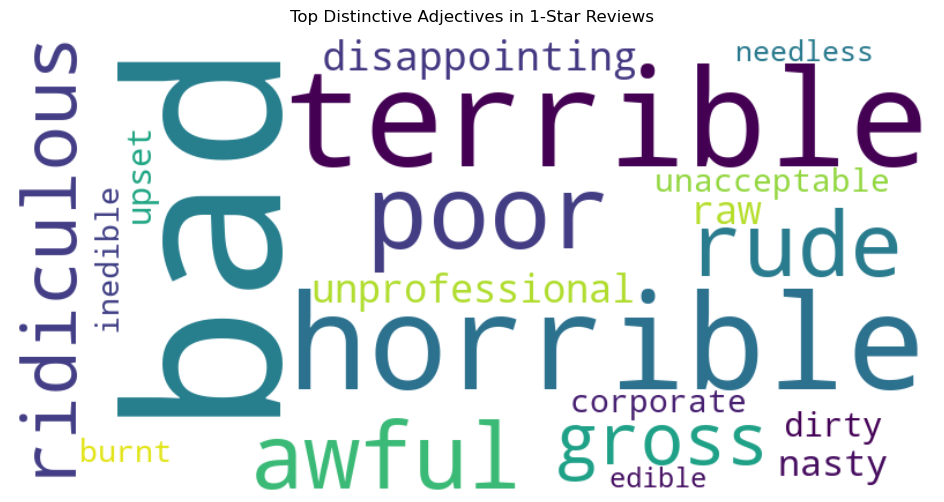

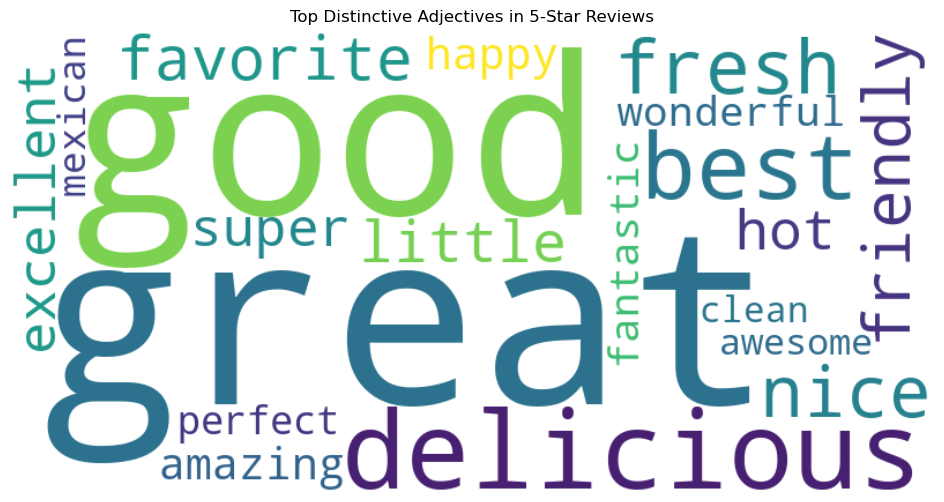

In [7]:
# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

# Function to extract adjectives
def get_top_adjectives(reviews_cleaned):
    # Flatten the list of tokenized reviews
    tokens = [word for review in reviews_cleaned for word in review]
    tagged = nltk.pos_tag(tokens)
    adjectives = [word for word, pos in tagged if pos.startswith('JJ') or pos.startswith('JJR') or pos.startswith('JJS')]
    lemmatized_adjectives = [lemmatizer.lemmatize(word, pos='a') for word in adjectives]
    return Counter(lemmatized_adjectives)

# Get adjectives for both star ratings
one_star_counter = get_top_adjectives(one_star_reviews_cleaned)
five_star_counter = get_top_adjectives(five_star_reviews_cleaned)

# Find adjectives that appear significantly more in one rating vs the other
one_star_unique = {}
five_star_unique = {}

for word in set(one_star_counter.keys()) | set(five_star_counter.keys()):
    one_count = one_star_counter.get(word, 0)
    five_count = five_star_counter.get(word, 0)
    
    # If adjective appears at least 3x more in one rating
    if one_count > five_count * 3 and word not in {"understand", "told", "sick", "speak"}:
        one_star_unique[word] = one_count
    elif five_count > one_count * 3 and word != "recommend":
        five_star_unique[word] = five_count

# Get top 20 adjectives for each rating
final_one_star = sorted(one_star_unique.items(), key=lambda x: x[1], reverse=True)[:20]
final_five_star = sorted(five_star_unique.items(), key=lambda x: x[1], reverse=True)[:20]

# Display results
print("Top 20 Distinctive Adjectives in 1-Star Reviews:")
for word, count in final_one_star:
    print(f"{word}: {count}")

print("\nTop 20 Distinctive Adjectives in 5-Star Reviews:")
for word, count in final_five_star:
    print(f"{word}: {count}")

# Prepare data for visualization
words_one_star, counts_one_star = zip(*final_one_star)
words_five_star, counts_five_star = zip(*final_five_star)

# Create word cloud for 1-star reviews
word_counts_one_star = dict(final_one_star)
wordcloud_one_star = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate_from_frequencies(word_counts_one_star)

# Display the word cloud for 1-star reviews
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud_one_star, interpolation='bilinear')
plt.axis('off')
plt.title('Top Distinctive Adjectives in 1-Star Reviews')
plt.show()

# Create word cloud for 5-star reviews
word_counts_five_star = dict(final_five_star)
wordcloud_five_star = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate_from_frequencies(word_counts_five_star)

# Display the word cloud for 5-star reviews
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud_five_star, interpolation='bilinear')
plt.axis('off')
plt.title('Top Distinctive Adjectives in 5-Star Reviews')
plt.show()

Top 20 Distinctive Verbs in 1-Star Reviews:
pay: 874
charge: 386
disgust: 316
throw: 248
suppose: 203
refuse: 198
ignore: 177
apologize: 164
state: 164
overprice: 157
mess: 136
proceed: 129
yell: 128
suck: 125
acknowledge: 124
waste: 110
act: 109
overcook: 102
burn: 100
ruin: 97

Top 20 Distinctive Verbs in 5-Star Reviews:
love: 4943
try: 3310
amaze: 3011
recommend: 2151
enjoy: 1440
stop: 1086
visit: 895
din: 842
fry: 803
add: 721
fill: 482
grill: 452
choose: 429
live: 416
season: 371
share: 365
welcome: 355
crave: 349
thank: 340
park: 315


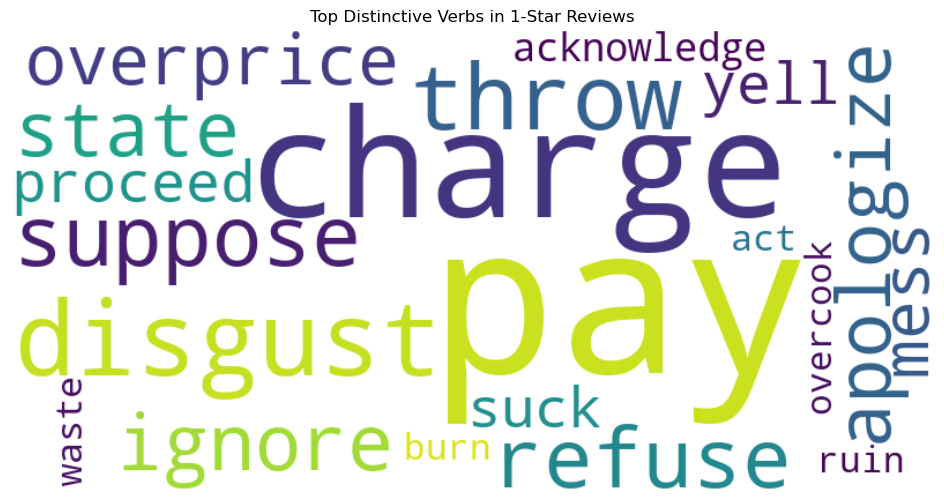

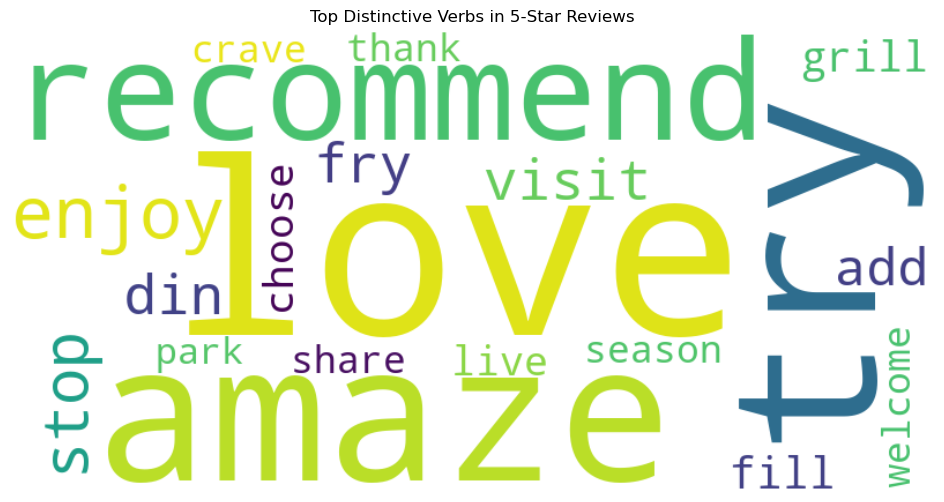

In [8]:
# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

# Function to extract verbs
def get_top_verbs(reviews_cleaned):
    # Flatten the list of tokenized reviews
    tokens = [word for review in reviews_cleaned for word in review]
    tagged = nltk.pos_tag(tokens)
    # Lemmatize verbs and filter by part of speech
    verbs = [lemmatizer.lemmatize(word, pos='v') for word, pos in tagged if pos in {'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ'}]
    return Counter(verbs)

# Get verbs for both star ratings
one_star_counter = get_top_verbs(one_star_reviews_cleaned)
five_star_counter = get_top_verbs(five_star_reviews_cleaned)

# Find verbs that appear significantly more in one rating vs the other
one_star_unique = {}
five_star_unique = {}

for word in set(one_star_counter.keys()) | set(five_star_counter.keys()):
    one_count = one_star_counter.get(word, 0)
    five_count = five_star_counter.get(word, 0)
    
    # If verb appears at least 3x more in one rating, excluding "rude"
    if one_count > five_count * 3 and word != "rude":
        one_star_unique[word] = one_count
    elif five_count > one_count * 3 and word != "price":
        five_star_unique[word] = five_count

# Get top 20 verbs for each rating
final_one_star_verbs = sorted(one_star_unique.items(), key=lambda x: x[1], reverse=True)[:20]
final_five_star_verbs = sorted(five_star_unique.items(), key=lambda x: x[1], reverse=True)[:20]

# Display results
print("Top 20 Distinctive Verbs in 1-Star Reviews:")
for word, count in final_one_star_verbs:
    print(f"{word}: {count}")

print("\nTop 20 Distinctive Verbs in 5-Star Reviews:")
for word, count in final_five_star_verbs:
    print(f"{word}: {count}")

# Prepare data for visualization for 1-star reviews
word_counts_verbs_one_star = dict(final_one_star_verbs)
wordcloud_verbs_one_star = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate_from_frequencies(word_counts_verbs_one_star)

# Display the word cloud for 1-star reviews
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud_verbs_one_star, interpolation='bilinear')
plt.axis('off')
plt.title('Top Distinctive Verbs in 1-Star Reviews')
plt.show()

# Prepare data for visualization for 5-star reviews
word_counts_verbs_five_star = dict(final_five_star_verbs)
wordcloud_verbs_five_star = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate_from_frequencies(word_counts_verbs_five_star)

# Display the word cloud for 5-star reviews
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud_verbs_five_star, interpolation='bilinear')
plt.axis('off')
plt.title('Top Distinctive Verbs in 5-Star Reviews')
plt.show()

# Code Cell 7
    Find the top 20 frequently used named entities from the selected reviews.


Top Unique Named Entities in 1 Star Reviews: [('McDonald', 33), ('McDonalds', 27), ("McDonald's", 27), ("Hungry Howie's", 22), ('KFC', 21), ('Taco Bell', 21), ('NEVER', 12), ('Karissa', 12), ('An', 12), ('Culver', 11), ('Panda Express', 11), ('Olive Garden', 10), ('Applebee', 10), ("Wendy's", 9), ('Korean', 9), ('Hilton', 8), ('Nashville', 7), ('AC', 7), ('GM', 7), ('patty', 7)]
Top Unique Named Entities in 5 Star Reviews: [('Tucson', 483), ('French', 67), ('Postino', 47), ('Sonoran', 47), ('Arizona', 46), ('Persian', 41), ('Indian', 41), ('Love', 32), ('Greek', 27), ('Kristi', 24), ('Hong Kong', 22), ('Prep & Pastry', 21), ('Ghini', 20), ('mexican', 17), ('Fresco', 16), ('Raijin', 14), ('BK', 13), ('Caesar', 12), ('Dee', 12), ('LeBuzz', 11)]


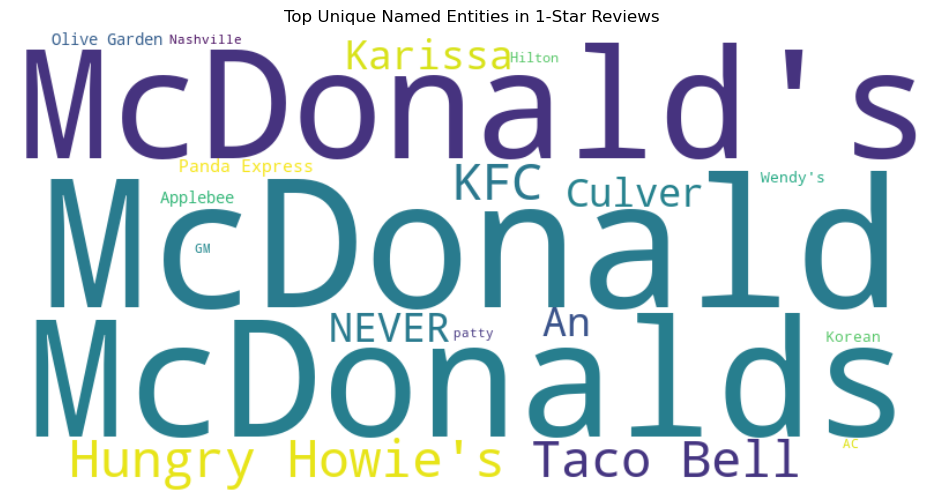

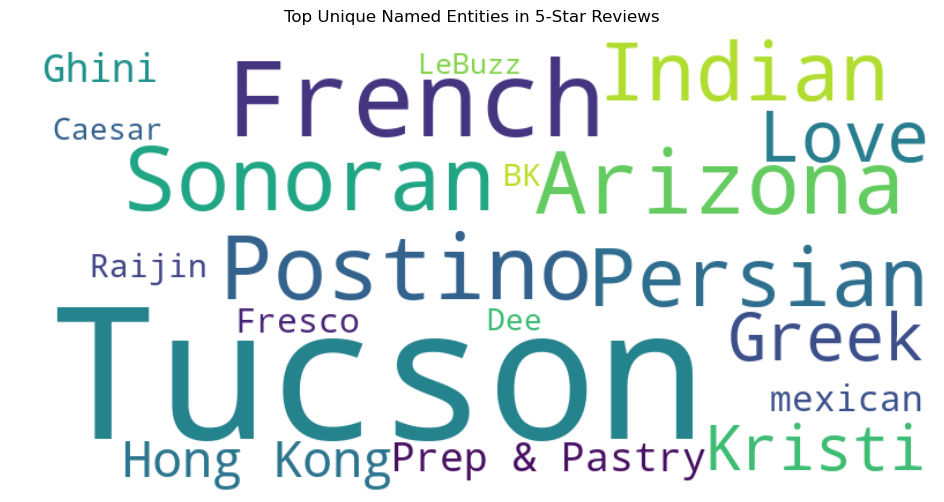

In [9]:
# Function to extract named entities using NER
def get_top_entities(reviews):
    # Check the length of the reviews and split if necessary
    max_length = nlp.max_length
    if len(reviews) > max_length:
        reviews = reviews[:max_length]  # Truncate to max_length
    doc = nlp(reviews)
    
    # Define a list of valid named entity types (excluding ordinal, cardinal, percent, time, or date)
    valid_entity_types = {'PERSON', 'NORP', 'ORG', 'GPE', 'FAC', 'PRODUCT', 'EVENT', 'WORK_OF_ART', 'LAW'}
    
    # Extract entities and filter out numbers and invalid types
    entities = [ent.text for ent in doc.ents if ent.label_ in valid_entity_types and not re.match(r'^\d+$', ent.text)]
    
    return Counter(entities)

# Get named entities for both star ratings
one_star_entities = get_top_entities(' '.join(one_star_reviews['text'].astype(str)))
five_star_entities = get_top_entities(' '.join(five_star_reviews['text'].astype(str)))

# Find entities that appear significantly more in one rating vs the other
one_star_unique = {}
five_star_unique = {}

for entity in set(one_star_entities.keys()) | set(five_star_entities.keys()):
    one_count = one_star_entities.get(entity, 0)
    five_count = five_star_entities.get(entity, 0)
    
    # If entity appears at least 3x more in one rating
    if one_count > five_count * 3:
        one_star_unique[entity] = one_count
    elif five_count > one_count * 3:
        five_star_unique[entity] = five_count

# Get top 20 entities for each rating
final_entities_one_star = sorted(one_star_unique.items(), key=lambda x: x[1], reverse=True)[:20]
final_entities_five_star = sorted(five_star_unique.items(), key=lambda x: x[1], reverse=True)[:20]

# Display results
print("Top Unique Named Entities in 1 Star Reviews:", final_entities_one_star)
print("Top Unique Named Entities in 5 Star Reviews:", final_entities_five_star)

# Prepare data for visualization for 1-star reviews
word_counts_entities_one_star = dict(final_entities_one_star)
wordcloud_entities_one_star = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate_from_frequencies(word_counts_entities_one_star)

# Display the word cloud for 1-star reviews
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud_entities_one_star, interpolation='bilinear')
plt.axis('off')
plt.title('Top Unique Named Entities in 1-Star Reviews')
plt.show()

# Prepare data for visualization for 5-star reviews
word_counts_entities_five_star = dict(final_entities_five_star)
wordcloud_entities_five_star = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate_from_frequencies(word_counts_entities_five_star)

# Display the word cloud for 5-star reviews
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud_entities_five_star, interpolation='bilinear')
plt.axis('off')
plt.title('Top Unique Named Entities in 5-Star Reviews')
plt.show()

# Text Cell 8

    Write one paragraph about your observation on the language of 1 star and 5 star reviews. What is the key to a good restaurant experience? 

The language used in 1-star reviews often reflects frustration and disappointment, highlighting specific issues such as poor service, unsatisfactory food quality, or unclean environments, even time and money. In contrast, 5-star reviews tend to emphasize positive experiences, showcasing exceptional service, delicious meals, and a welcoming atmosphere, utilizing unique words and phrases to describe the experience. The key to a good restaurant experience lies in the ability to consistently meet or exceed customer expectations, creating a memorable dining experience that encourages patrons to return and recommend the establishment to others. Effective communication, attentive service, and a commitment to quality are essential components that can significantly influence customer satisfaction and loyalty.

# Text Cell 9

    This assignment utilized GenAI tools for assistance in generating code and analyzing text data.
    
    I collaborated with chatgpt, claude sonnet and cursor to enhance the functionality of the review analysis.

    I also collaborated with Zach Guccione to test our hypothesis and develop the code for higher due diligence and peer review.

